<h1><center>Cō Vidis?</center></h1>

<center><b>Cō Vidis?</b> [kʷoː ˈwɪːdɪs] ➡️ latin for "COVID-19, where are you going?"<br/>
Follow the state of the Coronavirus with a focus on Switzerland 🇨🇭</center>


In [72]:
%%html
<style>
    div#notebook-container {
      padding: 40px;
    }
    
    div#notebook {
      padding-top: 40px;
      padding-bottom: 60px;
    }

    div.prompt {
      display: none !important;
    }
    
    div.output_subarea {
      margin: 0 auto !important;
    }
</style>

## Imports

In [2]:
import math
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import geopandas as gpd
import geoplot as gplt
import mapclassify as mc
import reverse_geocoder as rg
import countrynames
import json
import plotly.graph_objects as go

sns.set(style="whitegrid")
%config InlineBackend.figure_format ='retina'

# The command to generate the HTML
# jupyter nbconvert covid-19.ipynb --TagRemovePreprocessor.remove_cell_tags='{"remove_cell"}' --TagRemovePreprocessor.remove_input_tags='{"remove_input"}'

## Functions

In [86]:
def create_by_country_dataframe(df):
    by_country = df.T
    by_country.columns = by_country.loc["Country/Region"]
    by_country = by_country[4:]
    by_country = by_country.groupby(axis=1, by=by_country.columns).sum()
    by_country.index = pd.to_datetime(by_country.index)
    return by_country

def setDatetimeIndex(df, datetime_column):    
    df['Datetime'] = pd.to_datetime(df[datetime_column])
    df = df.set_index('Datetime')
    df = df.drop([datetime_column], axis=1)
    return df

def add_alpha_3(df):
    #df = pd.DataFrame(df.sum(axis=0))
    #df = df.rename(columns={0:"Cases"})
    #df = df.reset_index()
    return pd.merge(df, df_countries_code, on="Country/Region")  

def round_up(x):
    return int(math.ceil(x / 100.0)) * 100

def is_it_spreading(df):
    return df.diff()

def fill(df):
    df = df.fillna(method="ffill")
    df = df.fillna(0)
    return df

def compute_on_x_inhabitant(value, population, x):
    return (x * value) / population


## Data Loading

In [4]:
data = "../data/raw/COVID-19-master/csse_covid_19_data/csse_covid_19_time_series/"
data_ch = "../data/raw/covid19-cases-switzerland-master/"

In [5]:
confirmed = f"{data}time_series_covid19_confirmed_global.csv"
deaths = f"{data}time_series_covid19_deaths_global.csv"
recovered = f"{data}time_series_covid19_recovered_global.csv"

confirmed_ch = f"{data_ch}covid19_cases_switzerland_openzh.csv"
deaths_ch = f"{data_ch}covid19_fatalities_switzerland_openzh.csv"
hospitalized_ch = f"{data_ch}covid19_hospitalized_switzerland_openzh.csv"
icu_ch = f"{data_ch}covid19_icu_switzerland_openzh.csv"
recovered_ch = f"{data_ch}covid19_released_switzerland_openzh.csv"

In [6]:
countries = "../data/external/countries.csv"
demographics_ch = f"{data_ch}demographics.csv"

In [7]:
df_confirmed = pd.read_csv(confirmed)
df_deaths = pd.read_csv(deaths)
df_recovered = pd.read_csv(recovered)

df_confirmed_ch = pd.read_csv(confirmed_ch)
df_deaths_ch = pd.read_csv(deaths_ch)
df_hospitalized_ch = pd.read_csv(hospitalized_ch)
df_icu_ch = pd.read_csv(icu_ch)
df_recovered_ch = pd.read_csv(recovered_ch)

df_countries = pd.read_csv(countries)
df_demographics_ch = pd.read_csv(demographics_ch)

In [8]:
df = {
    "confirmed": df_confirmed,
    "deaths": df_deaths,
    "recovered": df_recovered
}

df_ch = {
    "confirmed": df_confirmed_ch,
    "deaths": df_deaths_ch,
    "hospitalized" : df_hospitalized_ch,
    "icu" : df_icu_ch,
    "recovered": df_recovered_ch
}

df_country_codes = df_countries[["name", "alpha-3", "alpha-2"]]
df_country_codes = df_country_codes.rename(columns={"name": 'Country/Region'})

## Preprocessing for the world by country

In [9]:
by_country = {
    "confirmed" : create_by_country_dataframe(df.get("confirmed")),
    "deaths" : create_by_country_dataframe(df.get("deaths")),
    "recovered" : create_by_country_dataframe(df.get("recovered"))
}

Compute the existing cases and add them to the Dictionnary

In [10]:
# Active cases = total confirmed - total recovered - total deaths
by_country["existing"] = by_country["confirmed"] - by_country["recovered"] - by_country["deaths"]

## Preprocessing for Switzerland

In [11]:
ch = {
    "confirmed" : setDatetimeIndex(df_ch["confirmed"], "Date"),
    "deaths" : setDatetimeIndex(df_ch["deaths"], "Date"),
    "hospitalized" : setDatetimeIndex(df_ch["hospitalized"], "Date"),
    "icu" : setDatetimeIndex(df_ch["icu"], "Date"),
    "recovered" : setDatetimeIndex(df_ch["recovered"], "Date")
}

In [24]:
by_canton = {
    "confirmed" : ch["confirmed"],
    "deaths" : ch["deaths"],
    "hospitalized" : ch["hospitalized"],
    "icu" : ch["icu"],
    "recovered" : ch["recovered"]
}

In [25]:
by_canton_filled = {
    "confirmed" : fill(by_canton["confirmed"]),
    "deaths" : fill(by_canton["deaths"]),
    "hospitalized" : fill(by_canton["hospitalized"]),
    "icu" : fill(by_canton["icu"]),
    "recovered" : fill(by_canton["recovered"])
}

Compute the existing cases and add them to the Dictionnary

In [26]:
by_canton_filled["existing"] = by_canton_filled["confirmed"] - by_canton_filled["recovered"] - by_canton_filled["deaths"]

## Regions of Interest

In [27]:
# For the world
CH = ["Switzerland"]
CH_neighbors = ["Italy", "France", "Liechtenstein", "Austria", "Germany"]
CH_neighbors_no_italy = ["France", "Liechtenstein", "Austria", "Germany"]

# Bulgaria, Cyprus and Romania are not in the list
# Switzerland has been added
EU = ["Switzerland","Austria","Belgium","Croatia","Denmark","Estonia","Finland","France","Germany","Greece","Hungary","Ireland","Italy","Latvia","Lithuania","Luxembourg","Malta","Netherlands","Poland","Portugal","Romania","Slovakia","Slovenia","Spain","Sweden"]
EU_no_italy = ["Switzerland","Austria","Belgium","Croatia","Denmark","Estonia","Finland","France","Germany","Greece","Hungary","Ireland","Latvia","Lithuania","Luxembourg","Malta","Netherlands","Poland","Portugal","Romania","Slovakia","Slovenia","Spain","Sweden"]


# For Switzerland
all_cantons = ["CH"]

## Period of Interest

In [28]:
last_n_days = 14

In [29]:
# For the world
existing = by_country.get("existing")[-last_n_days:]
confirmed = by_country.get("confirmed")[-last_n_days:]
deaths = by_country.get("deaths")[-last_n_days:]
recovered = by_country.get("recovered")[-last_n_days:]

# For CH
existing_ch = by_canton_filled.get("existing")[-last_n_days:]
confirmed_ch = by_canton_filled.get("confirmed")[-last_n_days:]
hospitalized_ch = by_canton_filled.get("hospitalized")[-last_n_days:]
deaths_ch = by_canton_filled.get("deaths")[-last_n_days:]
recovered_ch = by_canton_filled.get("recovered")[-last_n_days:]

## Switzerland

In [163]:
#swiss_map_path = "../data/external/swiss-maps/ch-country.json"
swiss_geojson_path = "../data/external/swiss-geojson/switzerland.geojson"
swiss_gdf = gpd.read_file(swiss_geojson_path)

with open(swiss_geojson_path, 'r') as j:
    swiss_geojson = json.loads(j.read())

canton_names = swiss_gdf[["id", "name"]]

last_day = {
    "existing" : by_canton_filled["existing"].iloc[-1].astype(int),
    "confirmed" : by_canton_filled["confirmed"].iloc[-1].astype(int),
    "deaths" : by_canton_filled["deaths"].iloc[-1].astype(int),
    "hospitalized" : by_canton_filled["hospitalized"].iloc[-1].astype(int),
    "icu" : by_canton_filled["icu"].iloc[-1].astype(int).astype(int),
    "recovered" : by_canton_filled["recovered"].iloc[-1].astype(int)
} 


last_day = pd.DataFrame([last_day["existing"], 
                last_day["confirmed"], 
                last_day["deaths"], 
                last_day["hospitalized"], 
                last_day["icu"], 
                last_day["recovered"]],
                index=["existing", "confirmed", "deaths", "hospitalized", "icu", "recovered"]).T

last_day = last_day.reset_index()
last_day = last_day.rename(columns={"index":"id"})
last_day = last_day.merge(canton_names, on="id")

df_demographics_cantons = df_demographics_ch.drop(index={26})
last_day = last_day.merge(df_demographics_cantons, left_on="id", right_on="Canton")

last_day["confirmed_per_10000"] = last_day.apply(lambda x : compute_on_x_inhabitant(x["confirmed"], x["Population"], 10000), axis=1).round(0)
last_day["confirmed_per_10000"] = last_day["confirmed_per_10000"].astype(int)

In [164]:
# Create the custom data

#last_day['confirmed'].astype(str) + "&nbsp;confirmed<br>" +\
#last_day['existing'].astype(str) + "&nbsp;existing<br>" +\
#last_day['recovered'].astype(str) + "&nbsp;recovered<br>" +\
#last_day['hospitalized'].astype(str) + "&nbsp;hospitalized<br>" +\
#last_day['icu'].astype(str) + "&nbsp;icu<br>" +\
#last_day['deaths'].astype(str) + "&nbsp;deaths"

last_day['text'] = last_day['confirmed'].astype(str) + "&nbsp;confirmed<br>" +\
                   last_day['hospitalized'].astype(str) + "&nbsp;hospitalized<br>" +\
                   last_day['deaths'].astype(str) + "&nbsp;deaths"

In [210]:
info = last_day[["id","confirmed_per_10000"]].copy()
info["text"] = info.apply(lambda x : f"<b>{x.confirmed_per_10000}</b>" , axis=1)

In [189]:
list(map(lambda x: f"<b>{x}</b>", list(get_cantonal_centres().columns.values)))

['<b>AG</b>',
 '<b>AR</b>',
 '<b>AI</b>',
 '<b>BE</b>',
 '<b>BL</b>',
 '<b>BS</b>',
 '<b>FR</b>',
 '<b>GE</b>',
 '<b>GL</b>',
 '<b>GR</b>',
 '<b>JU</b>',
 '<b>LU</b>',
 '<b>NE</b>',
 '<b>NW</b>',
 '<b>OW</b>',
 '<b>SH</b>',
 '<b>SZ</b>',
 '<b>SO</b>',
 '<b>SG</b>',
 '<b>TG</b>',
 '<b>TI</b>',
 '<b>UR</b>',
 '<b>VD</b>',
 '<b>VS</b>',
 '<b>ZG</b>',
 '<b>ZH</b>']

In [209]:
def get_cantonal_centres():
    return pd.DataFrame({
        "AG": {"lat": 47.40966, "lon": 8.15688},
        "AR": {"lat": 47.366352 - 0.01, "lon": 9.36791 - 0.084},
        "AI": {"lat": 47.317264, "lon": 9.416754},
        "BE": {"lat": 46.823608, "lon": 7.636667},
        "BL": {"lat": 47.45176 - 0.03, "lon": 7.702414 + 0.06},
        "BS": {"lat": 47.564869 + 0.09, "lon": 7.615259},
        "FR": {"lat": 46.718391, "lon": 7.074008},
        "GE": {"lat": 46.220528 - 0.03, "lon": 6.132935 - 0.06},
        "GL": {"lat": 46.981042, "lon": 9.065751},
        "GR": {"lat": 46.656248, "lon": 9.628198},
        "JU": {"lat": 47.350744, "lon": 7.156107},
        "LU": {"lat": 47.067763, "lon": 8.1102},
        "NE": {"lat": 46.995534, "lon": 6.780126},
        "NW": {"lat": 46.926755, "lon": 8.405302 + 0.006},
        "OW": {"lat": 46.854527, "lon": 8.244317 - 0.02},
        "SH": {"lat": 47.71357, "lon": 8.59167 - 0.05},
        "SZ": {"lat": 47.061787, "lon": 8.756585},
        "SO": {"lat": 47.304135 + 0.02, "lon": 7.639388 + 0.02},
        "SG": {"lat": 47.2332 - 0.07, "lon": 9.274744},
        "TG": {"lat": 47.568715, "lon": 9.091957},
        "TI": {"lat": 46.295617, "lon": 8.808924},
        "UR": {"lat": 46.771849, "lon": 8.628586},
        "VD": {"lat": 46.570091, "lon": 6.657809 - 0.1},
        "VS": {"lat": 46.209567, "lon": 7.604659},
        "ZG": {"lat": 47.157296, "lon": 8.537294},
        "ZH": {"lat": 47.41275, "lon": 8.65508},
    })

fig = go.Figure(data=go.Choropleth( 
    geojson=swiss_geojson,
    locations=last_day["id"],
    name="",
    z=last_day["confirmed_per_10000"],
    text=last_day["name"],
    customdata=last_day["text"],
    hovertemplate="<b>%{text}</b><br>"+\
                  "%{z} per 10'000<br>"+\
                  "%{customdata}",
    showscale=True,
    colorscale="YlOrRd",
    colorbar={
        "xanchor": "left",
        "yanchor": "middle",
        "thickness": 16,
        "len":0.6,
        "outlinewidth": 1,
        "tickmode": "array",
        "tick0":0,
        "nticks":10,
        "dtick":10,
        "ticks": "outside",
        "title": {"text": "Cases&#8201;/&#8201;10'000<br>inhabitants🧍"}
    }
))

fig.update_geos(
    visible=False,
    center={"lat":46.798333, "lon":8.231944}, # The center of Switzerland 
    domain={"x": [0, 1], "y":[0, 1]},
    showframe=False,
    lonaxis={"range" : [5.05, 10.07]},
    lataxis={"range" : [45.49, 47.94]},
)


fig.add_trace(go.Scattergeo(
    lat=list(get_cantonal_centres().loc["lat"].values),
    lon=list(get_cantonal_centres().loc["lon"].values),
    textfont={
        "color": "#000",
        "family": "Arial",
        "size": 12,
    },
    mode="text",
    name="",
    #text=list(map(lambda x: f"<b>{x}</b>", list(get_cantonal_centres().columns.values))),
    text=info["text"],
    textposition=["top center"],
    hoverinfo="none"
))



fig.update_layout(
    geo={
        'projection_type': "mercator",
        'projection.scale': 1.05,
    },
    autosize=True,
    margin={"r":0,"t":0,"l":0,"b":0},
    height=600,
    
)

fig.show(
     config={
         'scrollZoom': False,
         'displayModeBar': False
     },
)

<center>☝️Hover on the map for some informations!💡</center>

---

In [33]:
# Linear Regression
df = existing_ch["CH"].diff()[1:]
X = df.index.factorize()[0].reshape(-1,1)
Y = df.values
m = LinearRegression().fit(X, Y)
Y_pred = m.predict(X)
Y_pred = pd.DataFrame(Y_pred)
Y_pred.index = df.index
Y_pred = Y_pred.rename(columns={0:"Trend"})

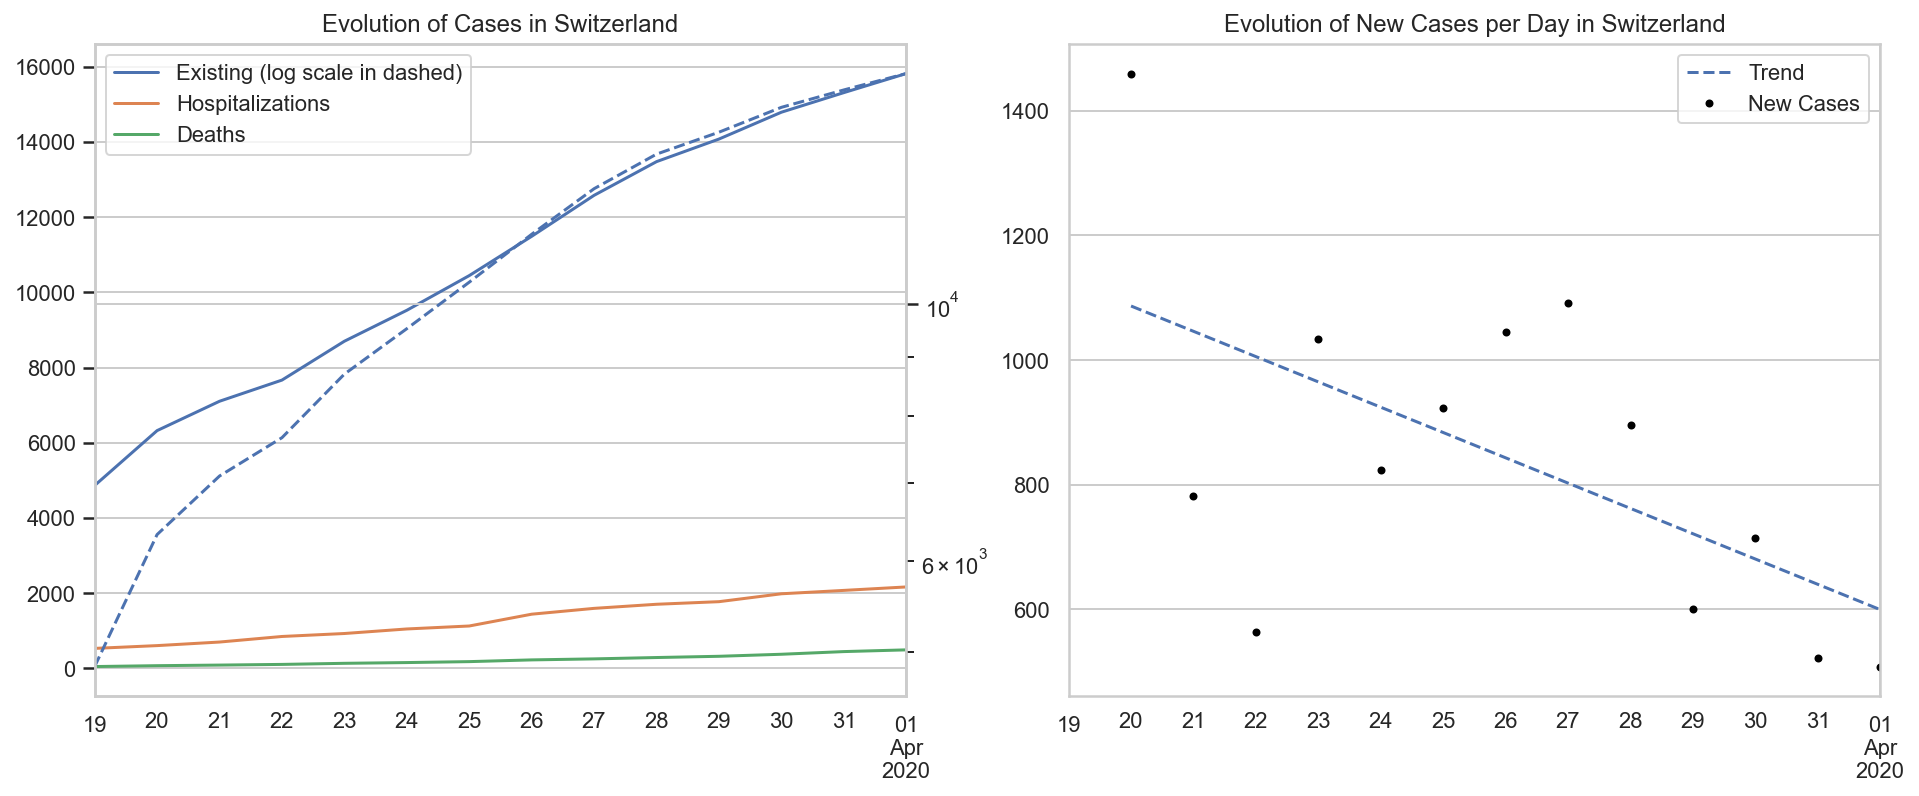

In [34]:
fig, (ax1, ax2) = plt.subplots(1,2)
    
ax1 = existing_ch[all_cantons].plot(ax=ax1, title="Evolution of Cases in Switzerland")
ax1 = hospitalized_ch[all_cantons].plot(ax=ax1)
ax1 = deaths_ch[all_cantons].sum(axis=1).plot(ax=ax1)
ax1.set_xlabel(None)
ax1log = ax1.twinx()
ax1log = existing_ch[all_cantons].sum(axis=1).plot(ax=ax1log, logy=True, style="--")

Y_pred.plot(ax=ax2, figsize=(16,6), style="--");
existing_ch[all_cantons].diff().plot(ax=ax2, style=".", color="black", title="Evolution of New Cases per Day in Switzerland");
ax2.set_xlabel(None)

ax1.legend(["Existing (log scale in dashed)", "Hospitalizations","Deaths"]);
ax2.legend(["Trend", "New Cases"]);

## Neighboring Countries

In [38]:
df1 = pd.DataFrame(by_country["existing"][CH_neighbors].iloc[-1].astype(int))
df1_ch = pd.DataFrame(by_canton_filled["existing"][all_cantons].iloc[-1].astype(int))

df2 = pd.DataFrame(by_country["deaths"][CH_neighbors].iloc[-1].astype(int))
df2_ch = pd.DataFrame(by_canton_filled["deaths"][all_cantons].iloc[-1].astype(int))

df1.rename(columns={df1.columns[-1]:"Existing"}, inplace=True)
df1_ch.rename(columns={df1_ch.columns[-1]:"Existing"}, index={'CH': 'Switzerland'}, inplace=True)
df1 = df1.append(df1_ch)

df2.rename(columns={df2.columns[-1]:"Deaths"}, inplace=True)
df2_ch.rename(columns={df2_ch.columns[-1]:"Deaths"}, index={'CH': 'Switzerland'}, inplace=True)
df2 = df2.append(df2_ch)

df = pd.concat([df1,df2], axis=1)
df = df.sort_values("Existing", ascending=False)

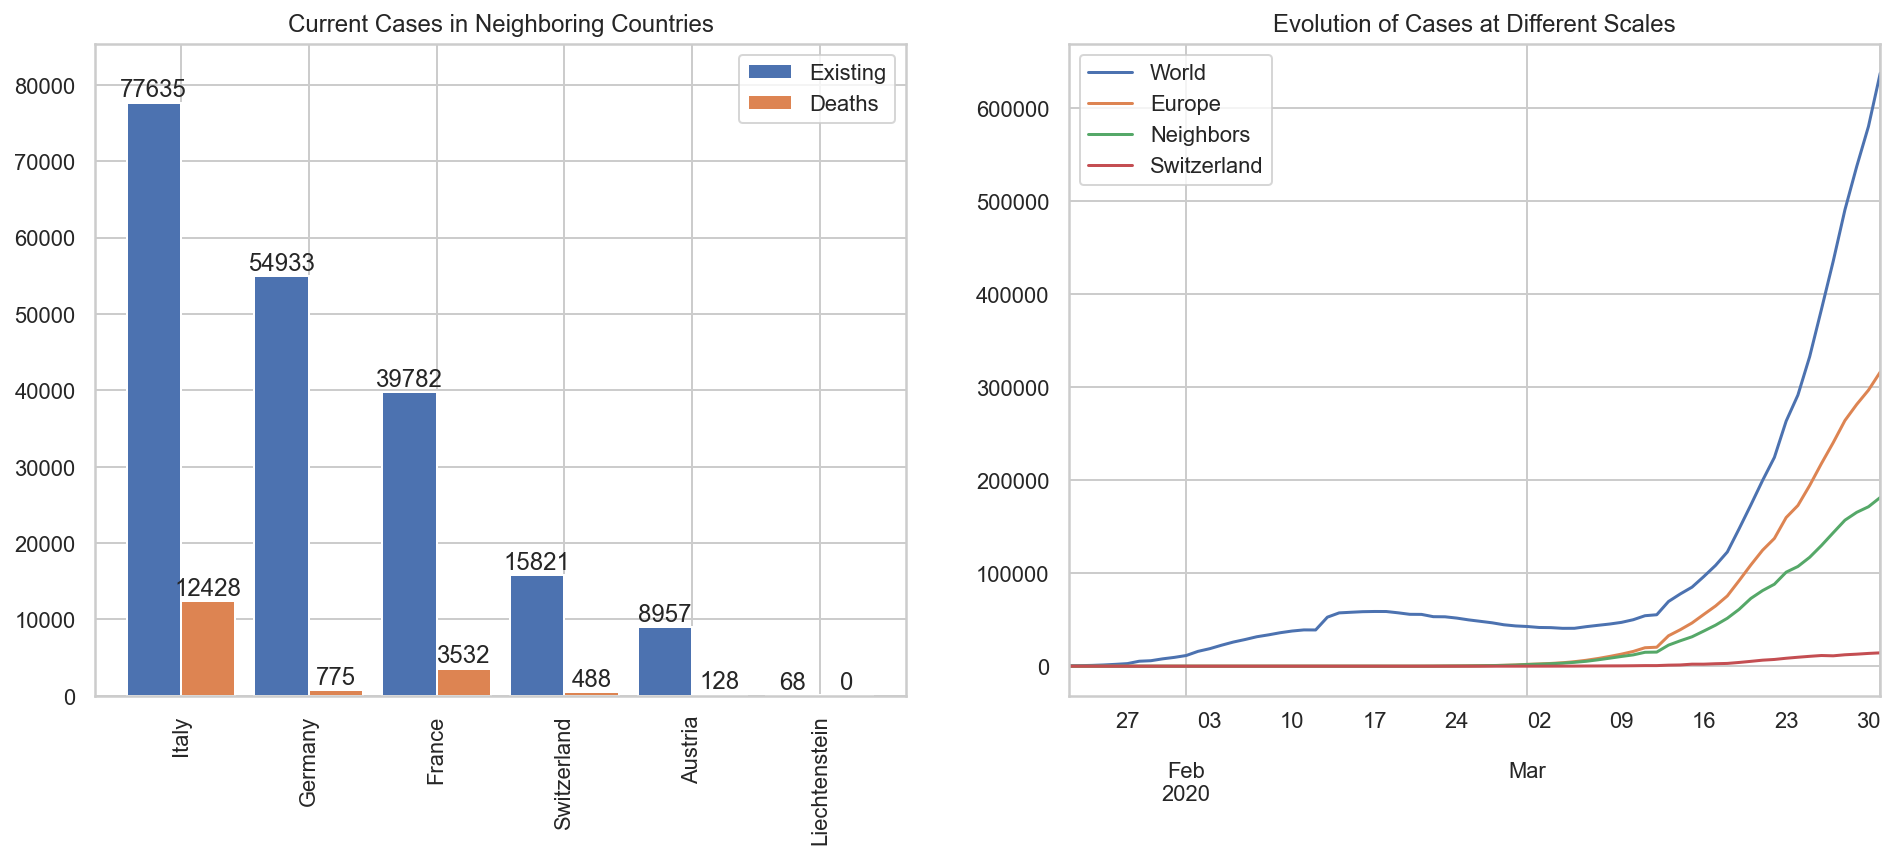

In [39]:
fig, (ax1, ax2) = plt.subplots(1,2)

ax1.grid(True)
ax1.set_ymargin(0.1)
df.plot.bar(title="Current Cases in Neighboring Countries", 
            ax=ax1, 
            width=0.85,
            figsize=(16,6));
for p in ax1.patches:
    ax1.annotate(str(p.get_height()), 
                 (p.get_x()+p.get_width()/2, p.get_height()+100), 
                 ha='center', 
                 va='center', 
                 xytext=(0, 6),
                 textcoords='offset points',
                 #fontweight="semibold",
                 rotation=0)

dfe = by_country["existing"]
dfe.sum(axis=1).plot(ax=ax2, title="Evolution of Cases at Different Scales");
dfe[EU].sum(axis=1).plot(ax=ax2)
dfe[CH_neighbors].sum(axis=1).plot(ax=ax2)
dfe[CH].sum(axis=1).plot(ax=ax2)

ax2.legend(["World", "Europe", "Neighbors", "Switzerland"]);

## World

⚠️ Plot in beta ⚠️

In [40]:
# Get iso alpha-2 from coords
data_countries=df_confirmed[["Lat", "Long", "Country/Region", "Province/State"]].copy()
data_countries["latlon"] = data_countries.apply(lambda x : (x.Lat, x.Long), axis=1)
codes = rg.search(data_countries["latlon"].to_list())
data_countries=df_confirmed[["Lat", "Long", "Country/Region", "Province/State"]]
data_countries["alpha-2"] = list(map(lambda x : x["cc"], codes))

Loading formatted geocoded file...


/Users/frederic.montet/.pyenv/versions/anaconda3-2019.10/envs/co-vidis/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [41]:
# Get existing cases data and preprocess it
last_existing = by_country["existing"].tail(1).T
last_existing = last_existing.reset_index()
last_existing = last_existing.rename(columns={last_existing.columns[1] : "Cases"})
last_existing = pd.merge(last_existing, data_countries, on='Country/Region', how="outer")
last_existing = last_existing.rename(columns={'Country/Region' : "name"})
last_existing["alpha-3"] = last_existing.apply(lambda x : countrynames.to_code_3(x["alpha-2"]), axis=1)

/Users/frederic.montet/.pyenv/versions/anaconda3-2019.10/envs/co-vidis/lib/python3.7/site-packages/countrynames/__init__.py:23: ICUWarning:

Install 'pyicu' for better text transliteration.



In [42]:
# Load the map and simplify it
gdf = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf = gdf[(gdf.name != "Antarctica") & (gdf.name != "Fr. S. Antarctic Lands")]
gdf = gdf.to_crs("EPSG:4326")

In [43]:
# Add some iso alpha 3 corrections
# See : gdf.loc[gdf["iso_a3"]=="-99"]

idx1 = gdf.loc[gdf["name"] == "Norway"].index.values[0]
idx2 = gdf.loc[gdf["name"] == "France"].index.values[0]
idx3 = gdf.loc[gdf["name"] == "N. Cyprus"].index.values[0]
idx4 = gdf.loc[gdf["name"] == "Somaliland"].index.values[0]
idx5 = gdf.loc[gdf["name"] == "Kosovo"].index.values[0]

gdf.at[idx1, "iso_a3"] = "NOR"
gdf.at[idx2, "iso_a3"] = "FRA"
gdf.at[idx3, "iso_a3"] = "CYP"
gdf.at[idx4, "iso_a3"] = "SOM"
gdf.at[idx5, "iso_a3"] = "XKX"

In [44]:
# Add Cases data to the GeoDataFrame
last_existing = last_existing.rename(columns={"alpha-3":"iso_a3"})
gdfc = gdf.merge(last_existing, on="iso_a3", how="left")
gdfc["Cases"].fillna(value=0, inplace=True)

In [45]:
# Make the scale divisions
s_1 = mc.FisherJenks(gdfc['Cases'], k=10)
bins = list(map(round_up, s_1.bins))
scheme = mc.UserDefined(gdfc['Cases'], bins=bins)

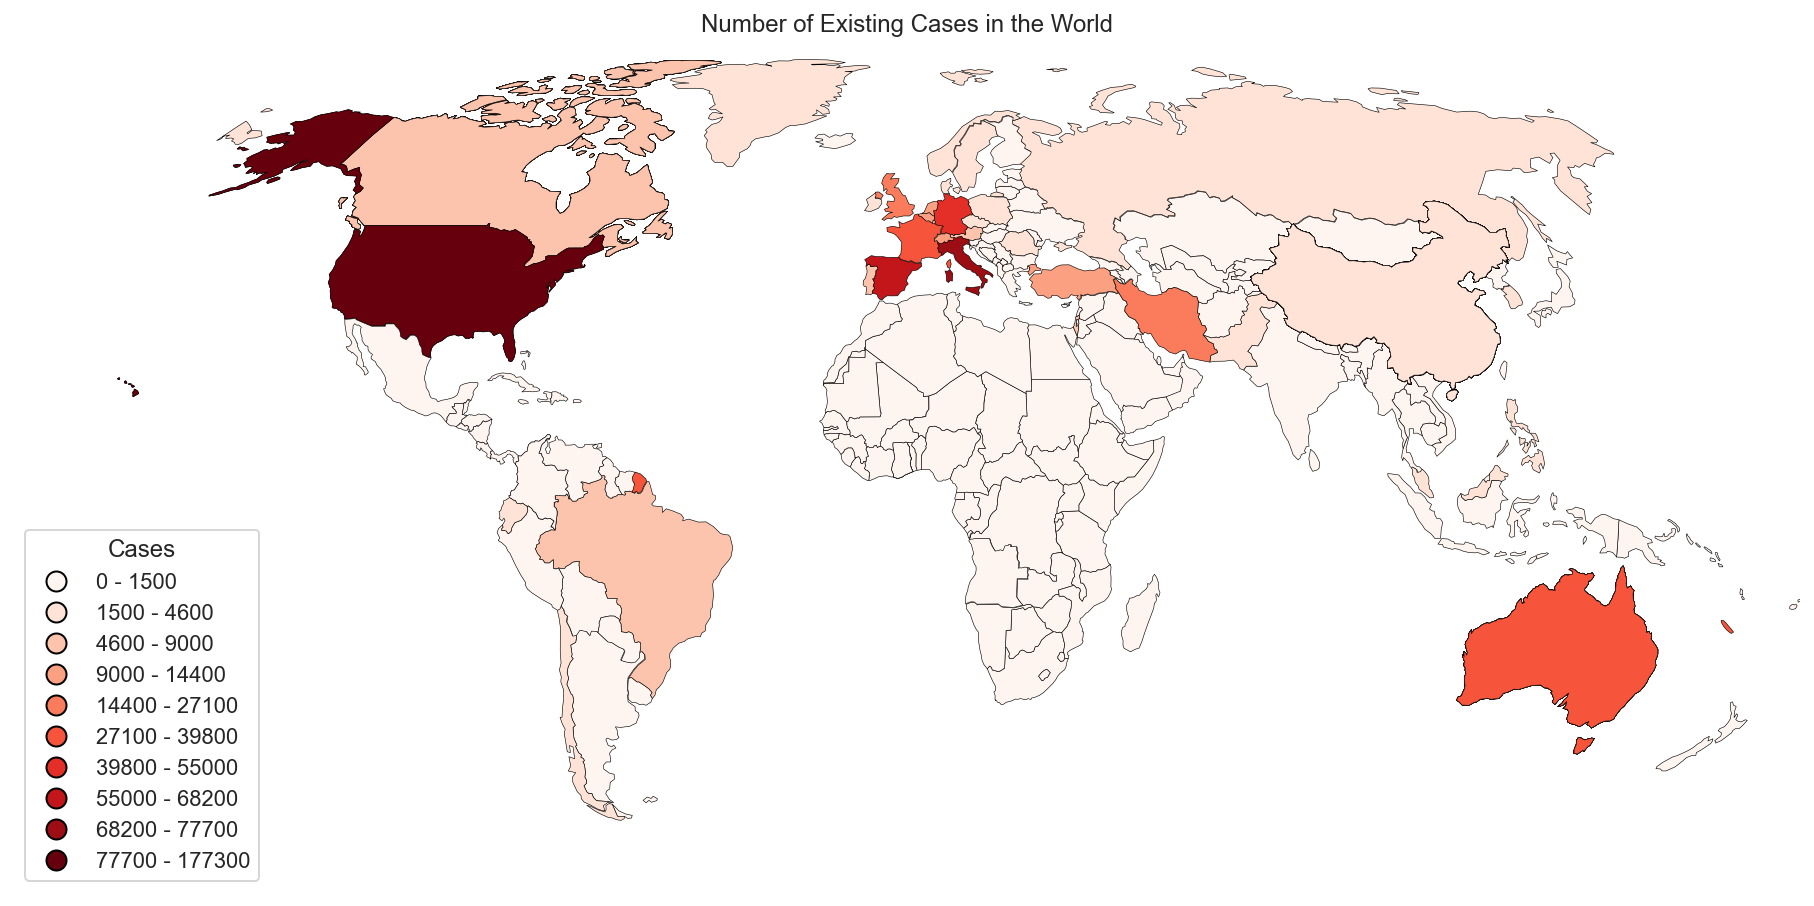

In [46]:
gplt.choropleth(gdfc,
                scheme=scheme,
                projection=gplt.crs.Robinson(), 
                hue='Cases', 
                cmap="Reds", 
                legend=True,
                figsize=(16,10),
                edgecolor="black",
                linewidth=0.3,
                legend_kwargs={
                    'title': "Cases",
                    'loc': 'lower left'}
);

plt.title("Number of Existing Cases in the World");

---
- **Author** : Fred Montet (https://twitter.com/fredmontet)
- **Repository** : https://github.com/fredmontet/co-vidis
- **Last Update**: ⬇️

In [67]:
print(f"World : {by_country['existing'].iloc[-1].name.date()} | Switzerland : {by_canton_filled['existing'].iloc[-1].name.date()}")

World : 2020-03-31 | Switzerland : 2020-04-01
